# RAG ARCHITECTURE DEMO

## LIBRARIES AND FUNCTIONS

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")
# Import required libraries
import boto3
import chromadb
from trino.dbapi import connect
from trino.auth import BasicAuthentication
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import pandas as pd
from pypdf import PdfReader
from langchain.document_loaders import PyPDFLoader
from tqdm import tqdm
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
import torch
import umap
import os, time
from langchain_community.vectorstores import Chroma
from langchain.chains import LLMChain
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from IPython.display import Audio
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-02-12 17:06:18.605974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 17:06:18.606025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 17:06:18.608363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 17:06:18.620411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 17:06:23.052727: W tensorflow/compiler/tf2

In [2]:
# Functions
def _read_pdf(filename):
    reader = PdfReader(filename) 
    print(reader)
    pdf_texts = [p.extract_text().strip() for p in reader.pages]
    pdf_texts = [text for text in pdf_texts if text] #Quitar cadenas vacías    
    return pdf_texts

def load_chroma(filename, collection_name, embedding_function, chunk_size, chunk_overlap):
    texts = _read_pdf(filename)
    chunks = _chunk_texts(texts, chunk_size, chunk_overlap)
    chroma_client = chromadb.Client()
    try:
        chroma_collection = chroma_client.create_collection(name=collection_name, embedding_function=embedding_function, metadata={"hnsw:space":"cosine"})
    except Exception as e:
        chroma_collection = chroma_client.get_collection(name=collection_name)
    ids = [str(i) for i in range(len(chunks))]
    meta = [{"fichero": filename} for i in range(len(chunks))]
    chroma_collection.add(ids=ids, documents=chunks, metadatas=meta)
    return chroma_collection

def word_wrap(string, n_chars=72):    
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)

def _chunk_texts(texts, chunk_size, chunk_overlap):     
    character_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", ". ", " ", ""],chunk_size=chunk_size,chunk_overlap=chunk_overlap)
    character_split_texts = character_splitter.split_text('\n\n'.join(texts))
    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256) 
    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)
    return token_split_texts

def project_embeddings(embeddings, umap_transform):    
    umap_embeddings = np.empty((len(embeddings),3))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

## READ LIST OF FILES FROM STARBURST

In [3]:
# Starburst
conn = connect(
    host='starburst.apps.mtc.openshift.vlab.local',
    port=443,
    verify=False,
    http_scheme="https",
    auth=BasicAuthentication('florej3', 'Changeme1!'),
    catalog='iceberg',
    roles={'iceberg': 'analyst'},
    schema='demo_rag'
)
cur = conn.cursor()
cur.execute("SELECT name FROM iceberg.demo_rag.docs")
list_of_files = [file[0] for file in cur.fetchall()]

## BREAK THE TEXT INTO "CHUNKS" TO LOAD THEM INTO CHROMADB

In [4]:
# S3 Client
ecs_endpoint = 'http://131408522096174073.public.ecstestdrive.com'
ecs_access_key_id = '131408522096174073@ecstestdrive.emc.com'
ecs_secret_key = 'o+aJUhILE90kDIRkOeK6/4S1mgbCMTiXo3mSZJdb'
s3 = boto3.client('s3', aws_access_key_id = ecs_access_key_id, aws_secret_access_key = ecs_secret_key, endpoint_url = ecs_endpoint)
#
bucket_name = 'docs'
location = '.cache_docs/'
if not os.path.exists(location):
    os.makedirs(location)
#
embedding_function = SentenceTransformerEmbeddingFunction()
for file in list_of_files:
    s3.download_file(bucket_name, file, location + file)
    chroma_collection = load_chroma(filename=location + file, collection_name='DOCS', embedding_function=embedding_function, chunk_size=1000, chunk_overlap=60)
print("Total number of chunks: " , chroma_collection.count())

Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9
Insert of existing embedding ID: 10
Insert of existing embedding ID: 11
Insert of existing embedding ID: 12
Insert of existing embedding ID: 13
Insert of existing embedding ID: 14
Insert of existing embedding ID: 15
Insert of existing embedding ID: 16
Insert of existing embedding ID: 17
Insert of existing embedding ID: 18
Insert of existing embedding ID: 19
Insert of existing embedding ID: 20
Insert of existing embedding ID: 21
Insert of existing embedding ID: 22
Insert of existing embedding ID: 23
Insert of existing embedding ID: 24
Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existin

Total number of chunks:  152


## REDUCE DIMENSIONALITY TO BE ABLE TO REPRESENT THE EMBEDDINGS

100%|██████████| 152/152 [02:12<00:00,  1.15it/s]


Text(0.5, 0.92, 'Projected Embeddings')

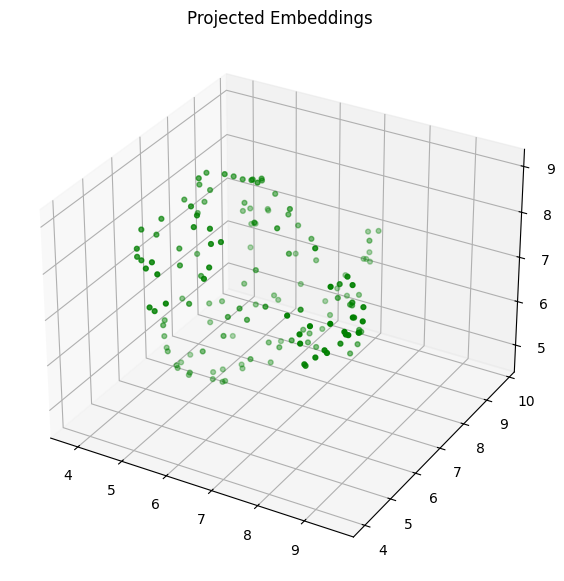

In [5]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0, n_jobs=1, n_components=3).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], projected_dataset_embeddings[:, 2], s=12, color = "green")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')

## ASK A QUESTION ON THE DATABASE SO THAT IT RETURN US THE 5 MOST SIMILAR CHUNKS AND THEIR LOCATION

In [6]:
query = "what is PowerScale CloudPools?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', 'metadatas'])
retrieved_documents = results['documents'][0]
retrieved_metadatos = results['metadatas'][0]
main_document = retrieved_documents[0]
for i,document in enumerate(results['documents'][0]):
    print("THE FILE CONTAINING THE FOLLOWING CHUNK IS: ", retrieved_metadatos[i])
    print("CHUNK TEXT: \n")
    print(word_wrap(document))
    print('')

THE FILE CONTAINING THE FOLLOWING CHUNK IS:  {'fichero': '.cache_docs/h18275-onefs-software-features-data-sheet.pdf'}
CHUNK TEXT: 

smartp ools allows for unprecedented flexibility, granularity, and ease
of management. smartpools aligns the business value of data with
optimal storage performance and cost by optimized data placement
including flash, hybrid, archive, and cloud storage. policy t riggers
that determine optimized data placement include criteria like file age,
size, type, owner, location, or date fields. by default, t he
smartpools jobs run nightly to apply new policies to the selected data
and seamlessly tier the files to the appropriate location based on your
requirements. capacity and performance - based data placement provide
even further granularity while improving storage efficiency. powerscale
cloudpools cloudpools software provides policy - based automated
tiering that lets you seamlessly integrate with the cloud as an
additional storage tier for the cluster. this al

## CONVERT THE QUERY INTO AN EMBEDDING AND PROJECT IT ALONG WITH THE RETURNED CHUNKS

100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Text(0.5, 0.92, 'what is PowerScale CloudPools?')

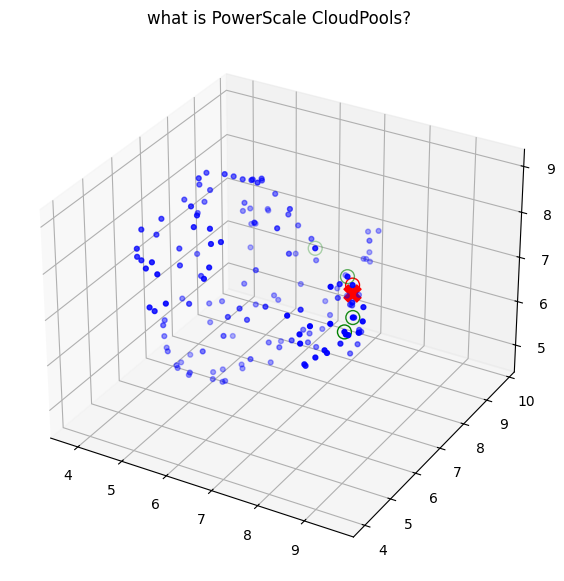

In [7]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], projected_dataset_embeddings[:, 2], s=12, color='blue')
ax.scatter3D(projected_query_embedding[:, 0], projected_query_embedding[:, 1], projected_query_embedding[:, 2], s=150, marker='X', color='r')
ax.scatter3D(projected_retrieved_embeddings[1:, 0], projected_retrieved_embeddings[1:, 1], projected_retrieved_embeddings[1:, 2], s=100, facecolors='none', edgecolors='g')
ax.scatter3D(projected_retrieved_embeddings[0, 0], projected_retrieved_embeddings[0, 1], projected_retrieved_embeddings[0, 2], s=100, facecolors='none', edgecolors='r')
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')

## LOAD AN EMBEDDINGS ENCODER TO RANK THE "CHUNKS" RETURNED ACCORDING TO THE QUESTION

In [8]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', device="cuda")
pairs_query = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs_query)
print("Score:")
for score in scores:
    print(score)

Score:
5.0773797
3.1973016
4.2141623
-1.9096495
-1.3686193


## WHAT IF WE ASK SOMETHING THAT IS NOT RELATED TO THE CONTENT OF THE DOCUMENT?

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Score:
-3.7468324
-2.6140954
-10.751245
-11.228356
-11.1144285


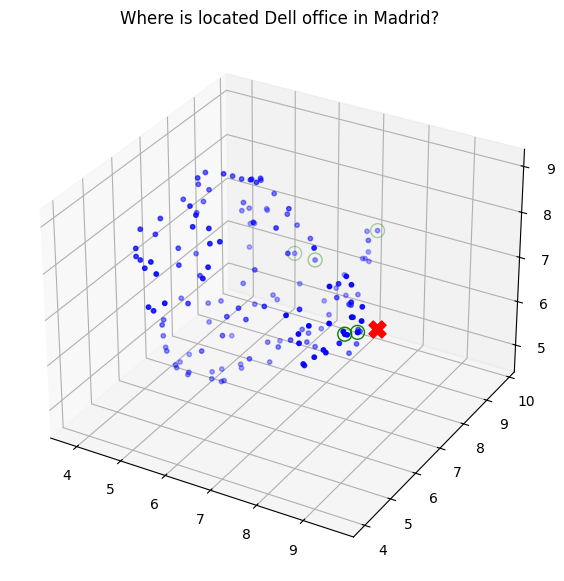

In [9]:
bad_query = "Where is located Dell office in Madrid?"
results = chroma_collection.query(query_texts=bad_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]
query_embedding = embedding_function([bad_query])[0]
retrieved_embeddings = results['embeddings'][0]
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],projected_dataset_embeddings[:, 2], s=10, color='blue')
ax.scatter3D(projected_query_embedding[:, 0], projected_query_embedding[:, 1],projected_query_embedding[:, 2], s=150, marker='X', color='r')
ax.scatter3D(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], projected_retrieved_embeddings[:, 2], s=100, facecolors='none', edgecolors='g')
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{bad_query}')
pairs_bad_query = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs_bad_query)
print("Score:")
for score in scores:
    print(score)

## LOAD A LARGE LANGUAGE MODEL LOCALLY (Google Flan-T5-XL / 3B parameters)

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-T5-XL", min_length=20, torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained("google/flan-T5-XL")
print("MEMORY RESERVED BY THE GPU: ",round(torch.cuda.memory_allocated(device)/1073741824,2), "GB")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MEMORY RESERVED BY THE GPU:  6.38 GB


## ASK THE QUESTION TO THE LLM AND SHOW THE RESULT IN TEXT AND AUDIO

In [11]:
inputs = tokenizer(f"""Answer as an IT expert the question based only on the following Context: "{main_document}"
Question: "{query}"
Answer: """, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
resultado = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(resultado[0])
from transformers import VitsModel, AutoTokenizer
import torch
model_texttovoice = VitsModel.from_pretrained("facebook/mms-tts-eng").to(device)
tokenizer_texttovoice = AutoTokenizer.from_pretrained("facebook/mms-tts-eng")
text = "The question was " + query + "And the answer to this question is " + resultado[0]
inputs = tokenizer_texttovoice(text, return_tensors="pt").to(device)
with torch.no_grad():
    output = model_texttovoice(**inputs).waveform
Audio(output.cpu().numpy(), rate=model_texttovoice.config.sampling_rate, autoplay=False)

cloudpools software provides policy - based automated tiering that lets you seamlessly integrate with the cloud as an additional storage tier for the cluster


Some weights of the model checkpoint at facebook/mms-tts-eng were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.1.wei

## WHAT IF WE ASK THE LLM DIRECTLY WITHOUT PROVIDING ANY TYPE OF CONTEXT?

In [12]:
inputs = tokenizer(f"""
Question: "{query}"
Answer: """, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
resultado = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(resultado)

['a software-defined networking (SDN) platform for delivering software-defined networking (SDN) services']
